## Imports and Path/Variable Definitions

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py
from scipy import signal
import argparse
import seaborn as sns
from datetime import date
import os
import X_gnss_unet_datagen_fn22 # Module with CNN/data generator code

sns.set_style('white')

project_name = 'newfault' # Based on the name of the FakeQuakes project
fq_dir = '/hdd/rc_fq/fall24/' # Where are the FakeQuakes stored? (The final .hdf5 file)
noise_dir = '/home/sdybing/gnss-picker/data/noisedata/' # Where is the noise data stored?
realdata_dir = '/home/sdybing/gnss-picker/data/realdata/summer23/' # Where is the real data stored?

cnn_save_dir = '/home/sdybing/gnss-picker/cnn_models_outputs/' # Where do you want to save this code's outputs?
project_save_dir = cnn_save_dir + project_name + '_fq_train/'
base_figure_save_dir = project_save_dir + 'base_data_figures/' # Where to save the figures of just the data/generator tests
models_path = project_save_dir + 'models/'
if os.path.isdir(project_save_dir):
    pass
else:
    os.makedirs(project_save_dir)
    os.makedirs(base_figure_save_dir)
    os.makedirs(models_path)
    
train = False # Do you want to train?
drop = 1 # Drop?
resume = 0 # Resume training
large = 0.5 # Large unet
fac = large
epochs = 100 # How many epochs?
std = 3 # How long do you want the Gaussian STD to be?
sr = 1 # Sample rate (Hz)
epsilon = 1e-6
batch_size = 32
load = True # Loading an old trained model?
small_train = False # Train with a smaller amount of data to make sure code works?
small_test = False # Test with a smaller amount of data to make sure code works?

2024-10-02 14:28:04.537591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-02 14:28:04.537611: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Loading and Formatting

### Load the Data

In [2]:
# FakeQuakes waveform data
print('Loading FakeQuakes...')
fq_data = h5py.File(fq_dir + 'newfault_fq_wvfm_data_formatted.hdf5', 'r')
fq_data = fq_data['data'][:,:]
# old_fq_data = h5py.File(fq_dir + 'july6_128samps_fq_wvfm_data_formatted.hdf5', 'r')
# old_fq_data = old_fq_data['data'][:,:]

# FakeQuakes metadata
print('Loading FakeQuakes metadata...')
fq_metadata = np.load(fq_dir + 'newfault_fq_wvfm_info.npy')

# Noise data
print('Loading noise...')
all_noise_data = h5py.File(noise_dir + 'summer23_128samps_all_noise_samples.hdf5', 'r')
all_noise_data = all_noise_data['all_noise_samples'][:,:]

# Demeaned real waveform data
print('Loading real data...')
real_data = h5py.File(realdata_dir + 'demean_realdata_rembad.hdf5', 'r')
real_data = real_data['demean_realdata_rembad'][:,:]

# Real metadata
print('Loading real metadata...')
real_metadata = np.load(realdata_dir + 'real_metadata_rembad_w_gauss_pos_mag.npy')

# Trim noise data to match length of FakeQuakes data
noise_data = all_noise_data[:len(fq_data)]

# Array of NaNs to use to match added noise in concatenation later
nan_array = np.empty((len(fq_data), 3))
nan_array[:] = np.NaN

# Real data

# Check shapes
print('FakeQuakes shape: ' + str(fq_data.shape))
print('Noise data shape: ' + str(noise_data.shape))
print('Real data shape: ' + str(real_data.shape))


Loading FakeQuakes...
Loading FakeQuakes metadata...
Loading noise...
Loading real data...
Loading real metadata...
FakeQuakes shape: (917400, 768)
Noise data shape: (917400, 768)
Real data shape: (994155, 384)


### Format and Split Training, Validation, and Testing Data

In [3]:
np.random.seed(27)

# Earthquake/signal data
fqinds = np.arange(fq_data.shape[0]) # Signal indices
np.random.shuffle(fqinds) # Shuffles the indices
train_fqinds = fqinds[:int(0.8*len(fqinds))] # Training data separation: grabs the front 80% of the numbers
valid_fqinds = fqinds[int(0.8*len(fqinds)):int(0.9*len(fqinds)):] # Grabs the next 10% (80-90%)
test_fqinds = fqinds[int(0.9*len(fqinds)):] # Grabs the last 10% (90%-end)

# Noise data
noiseinds = np.arange(noise_data.shape[0]) # Noise indices
np.random.shuffle(noiseinds) # Shuffles the indices
train_noiseinds = noiseinds[:int(0.8*len(noiseinds))] # Data separation as above
valid_noiseinds = noiseinds[int(0.8*len(noiseinds)):int(0.9*len(noiseinds))]
test_noiseinds = noiseinds[int(0.9*len(noiseinds)):]

# Check shapes to confirm compatability
print('Full FakeQuakes data shape: ' + str(fqinds.shape))
print('FakeQuakes training data shape: ' + str(train_fqinds.shape))
print('FakeQuakes validation data shape: ' + str(valid_fqinds.shape))
print('FakeQuakes testing data shape: ' + str(test_fqinds.shape))
print('Full noise data shape: ' + str(noiseinds.shape))
print('Noise training data shape: ' + str(train_noiseinds.shape))
print('Noise validation data shape: ' + str(valid_noiseinds.shape))
print('Noise testing data shape: ' + str(test_noiseinds.shape))


Full FakeQuakes data shape: (917400,)
FakeQuakes training data shape: (733920,)
FakeQuakes validation data shape: (91740,)
FakeQuakes testing data shape: (91740,)
Full noise data shape: (917400,)
Noise training data shape: (733920,)
Noise validation data shape: (91740,)
Noise testing data shape: (91740,)


## Test of Data Generator

Data generator check original data shape: (32, 128, 3)
Data generator check normalized data shape: (32, 128, 3)
Data generator check target shape: (32, 128)
Data generator check metadata shape: (32, 3)


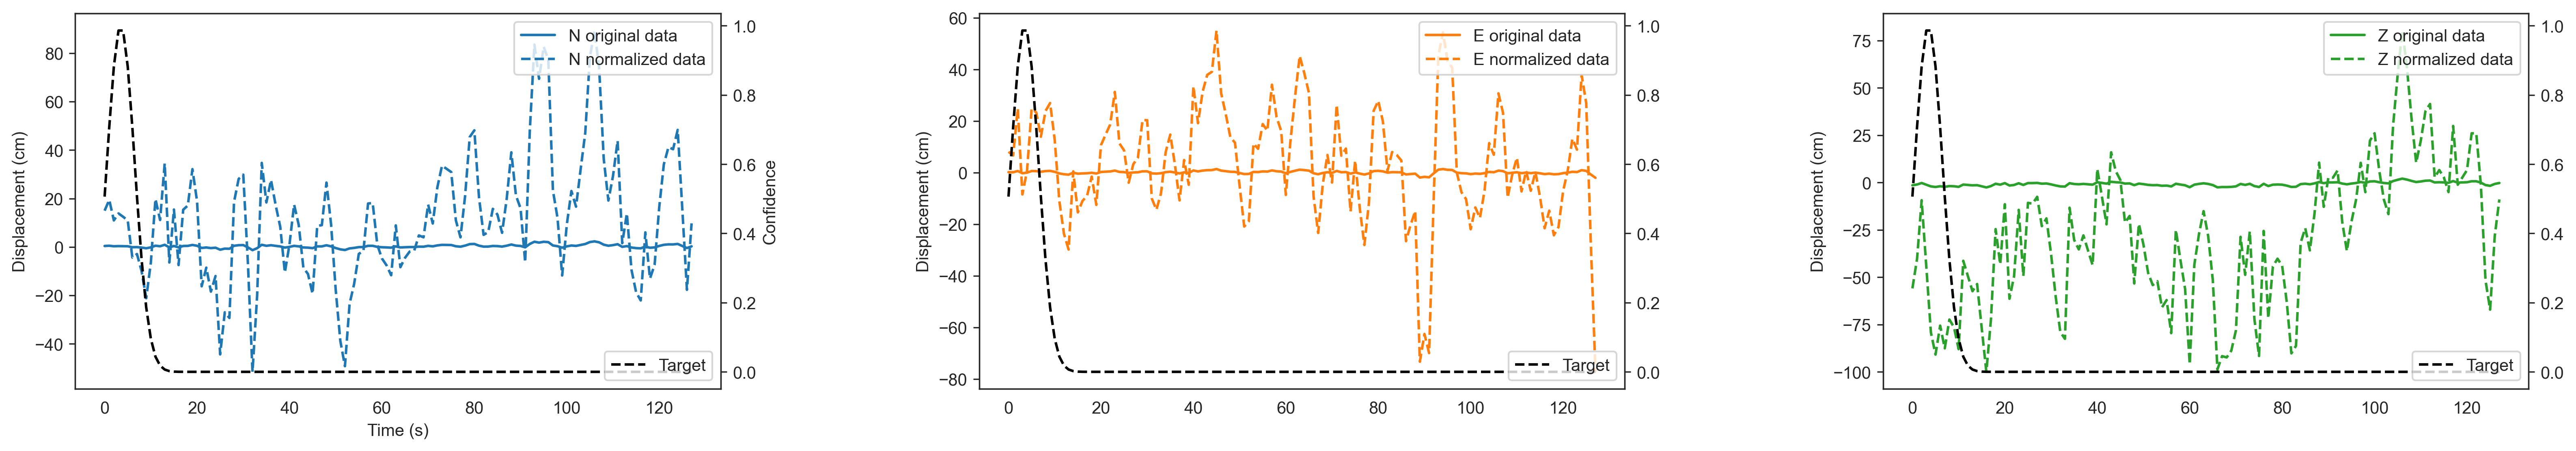

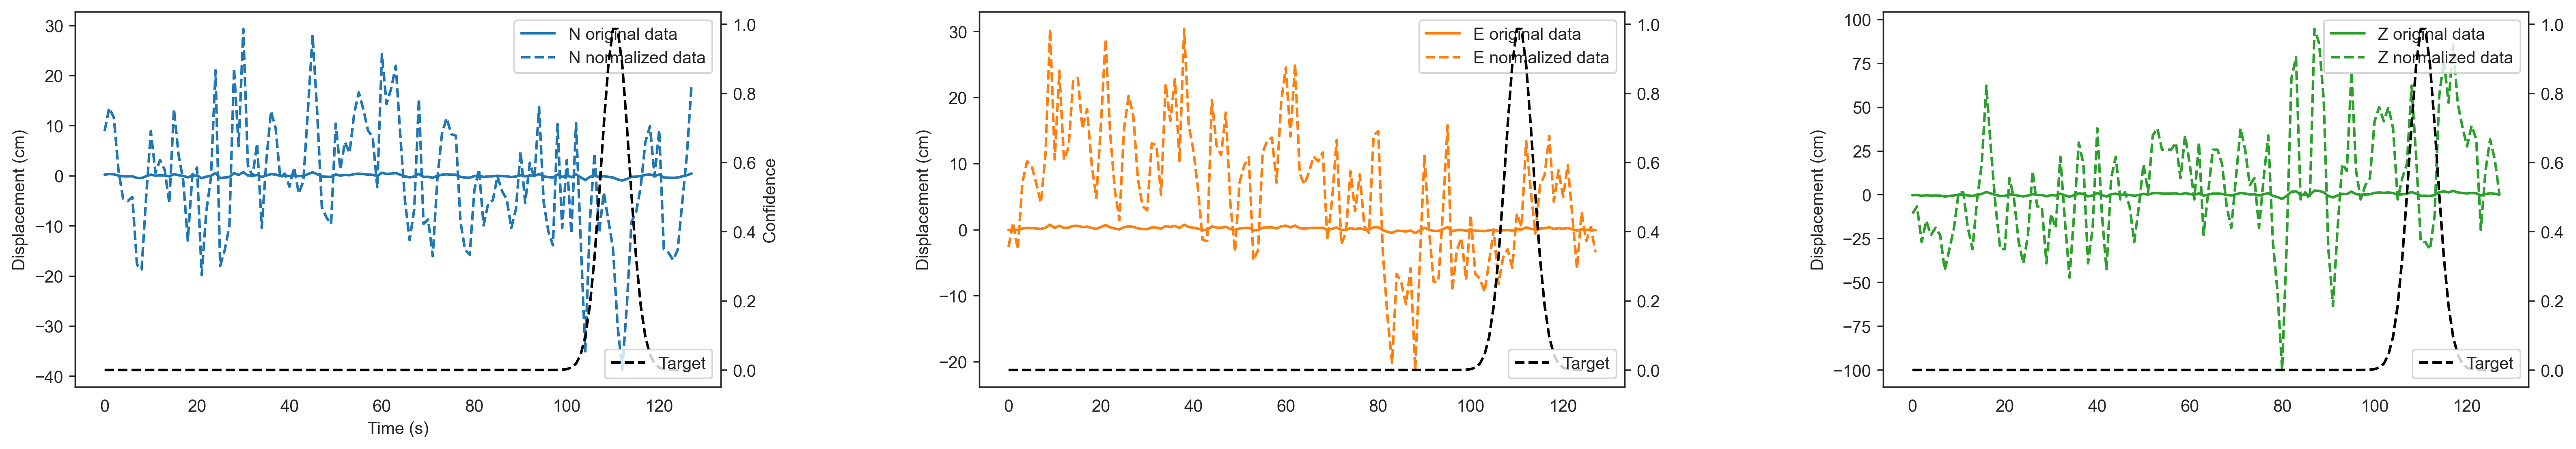

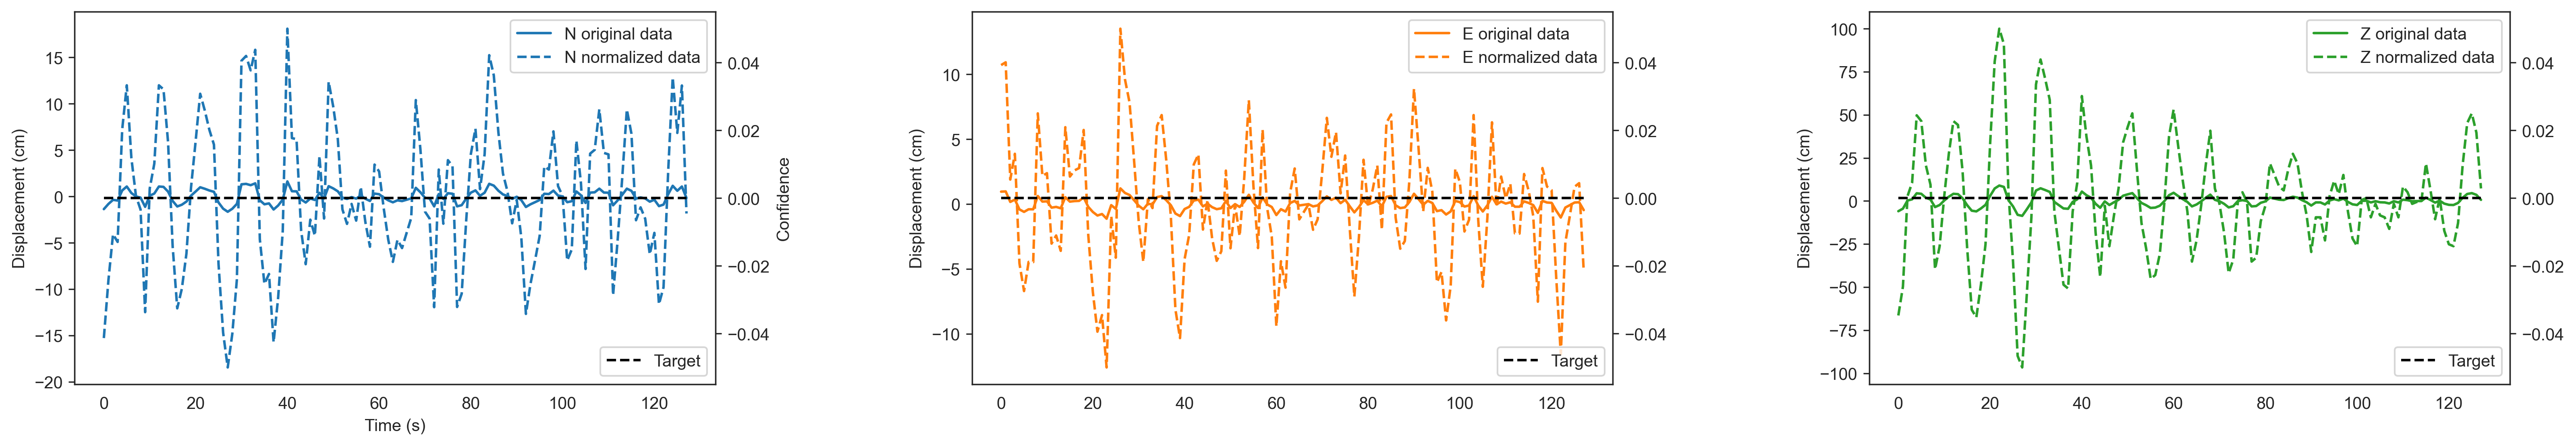

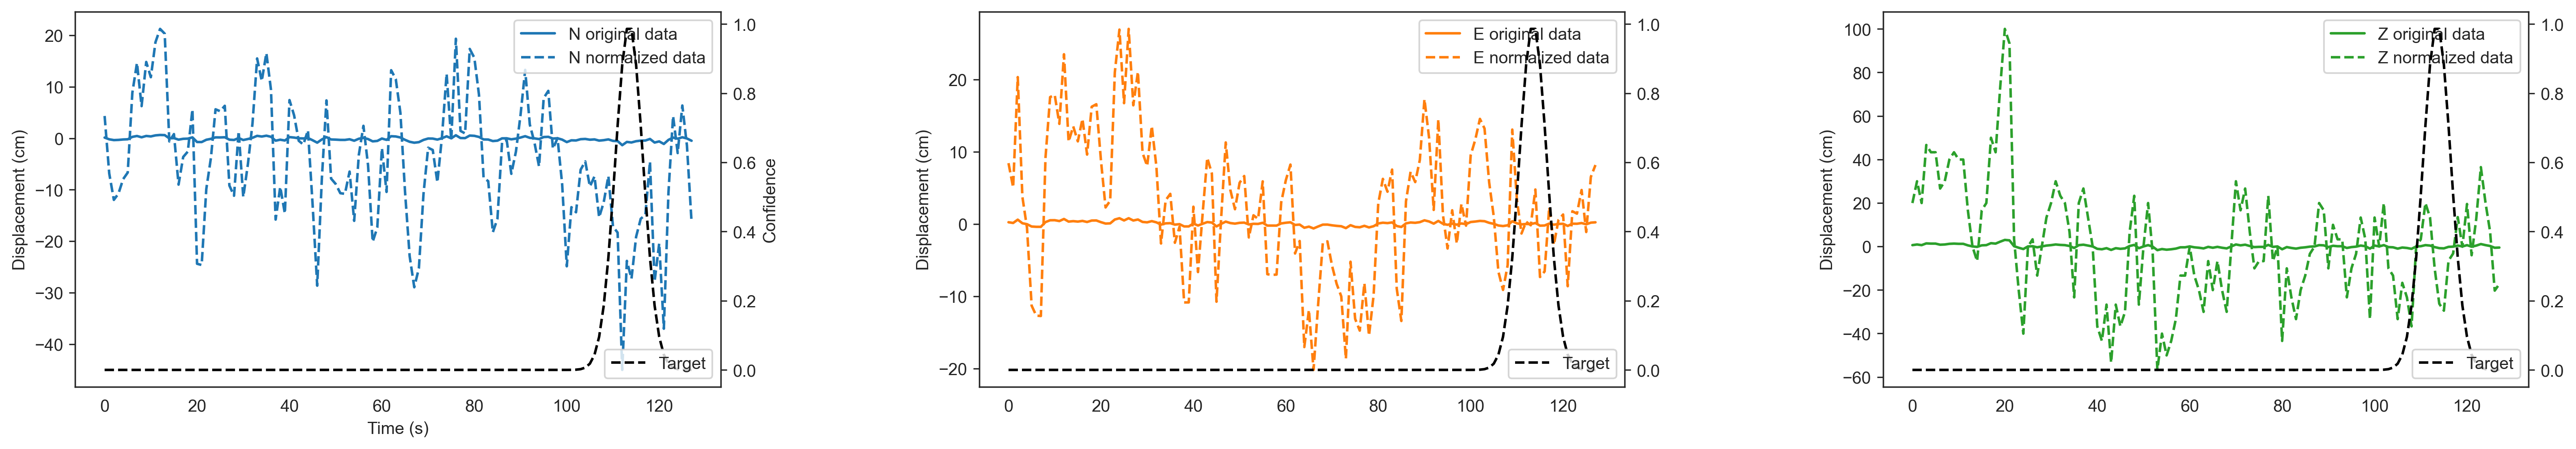

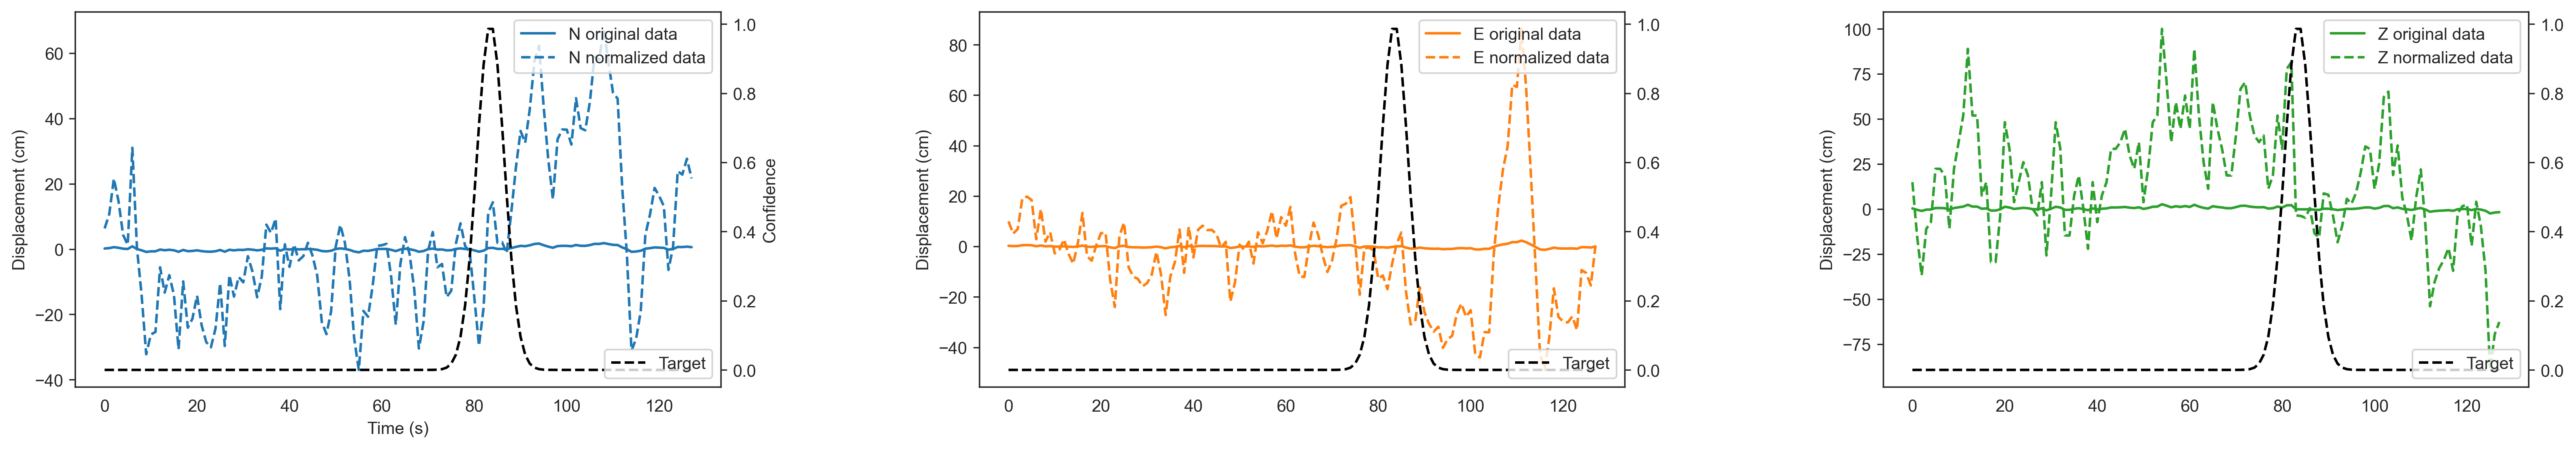

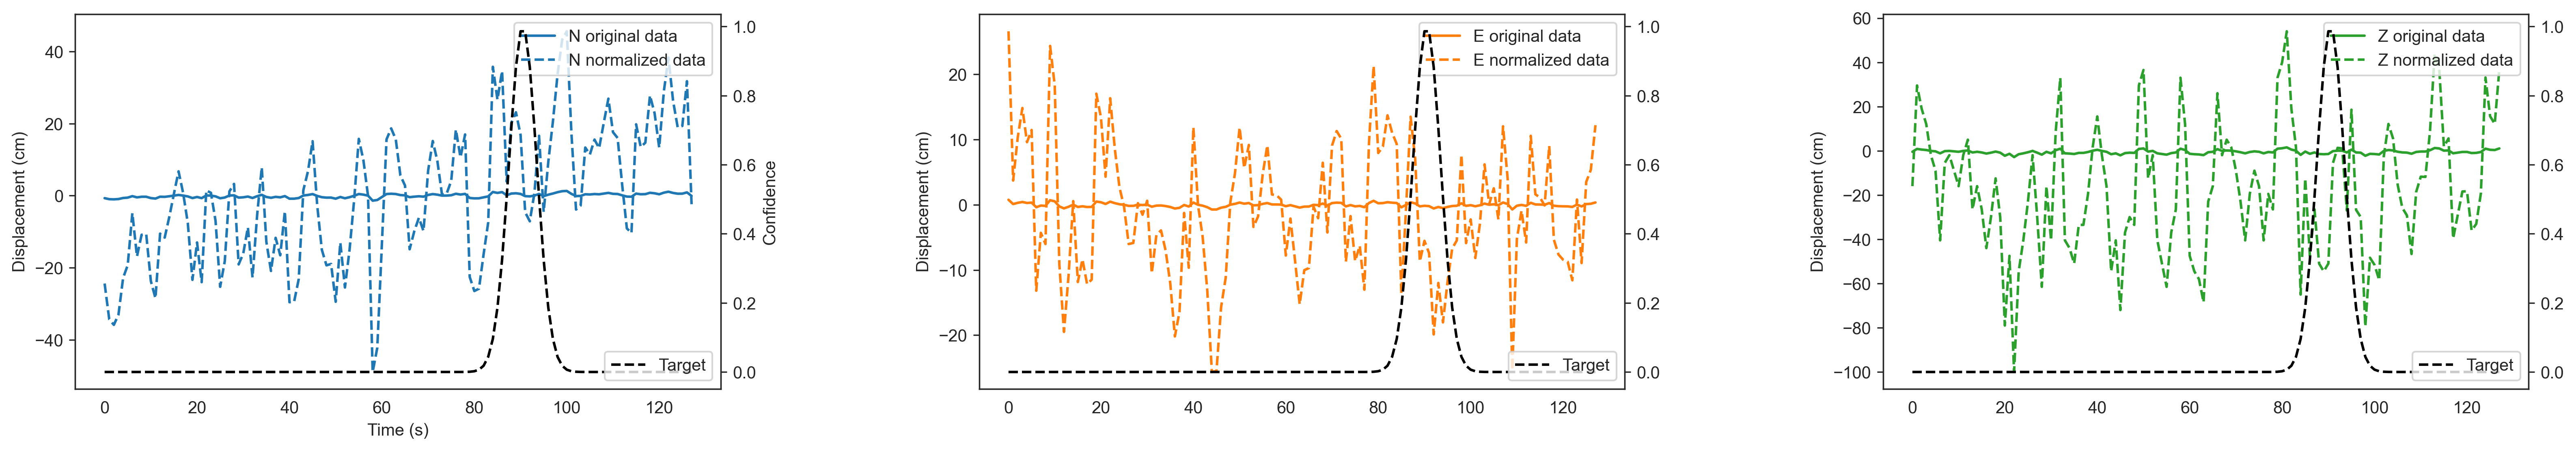

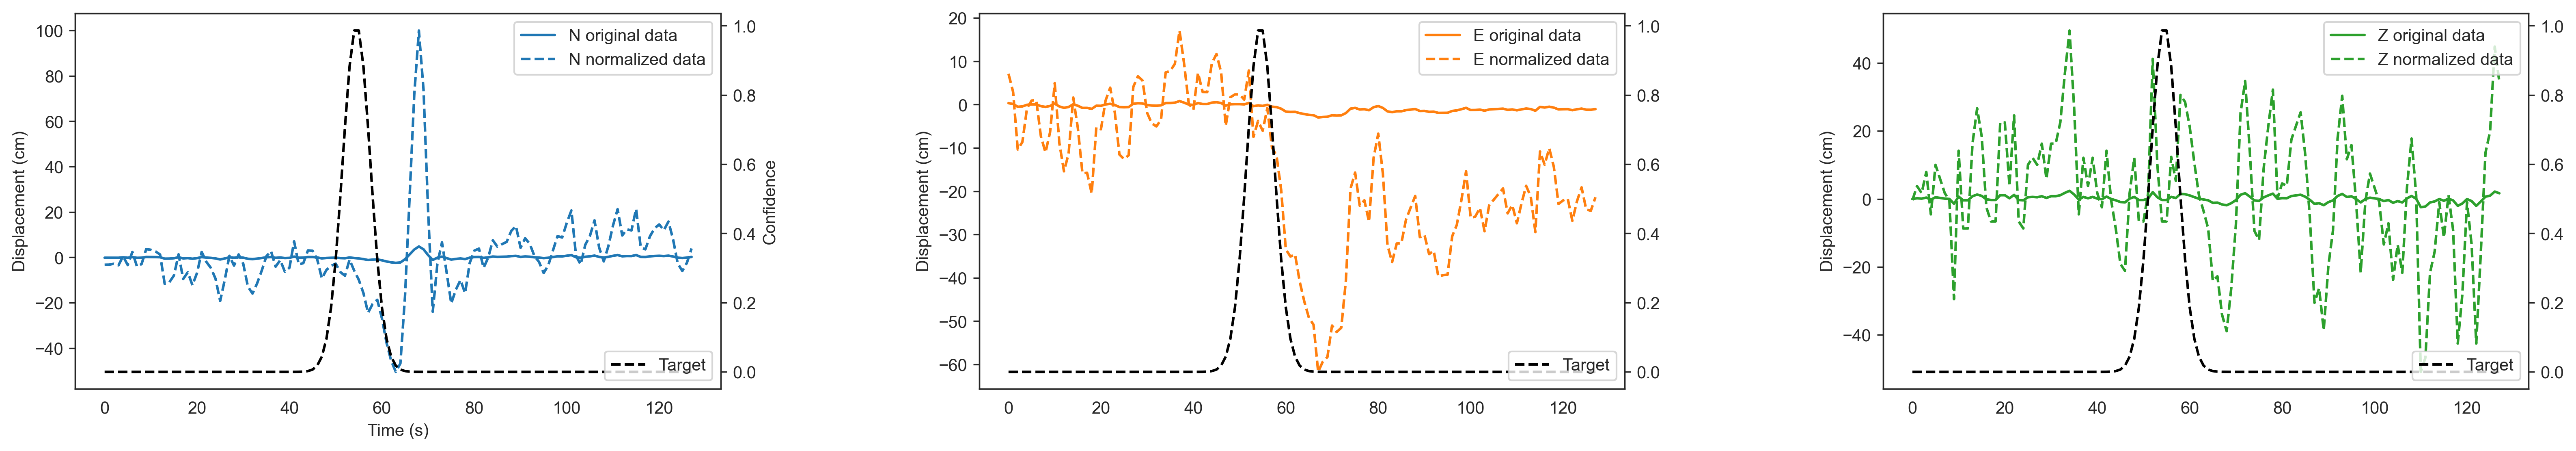

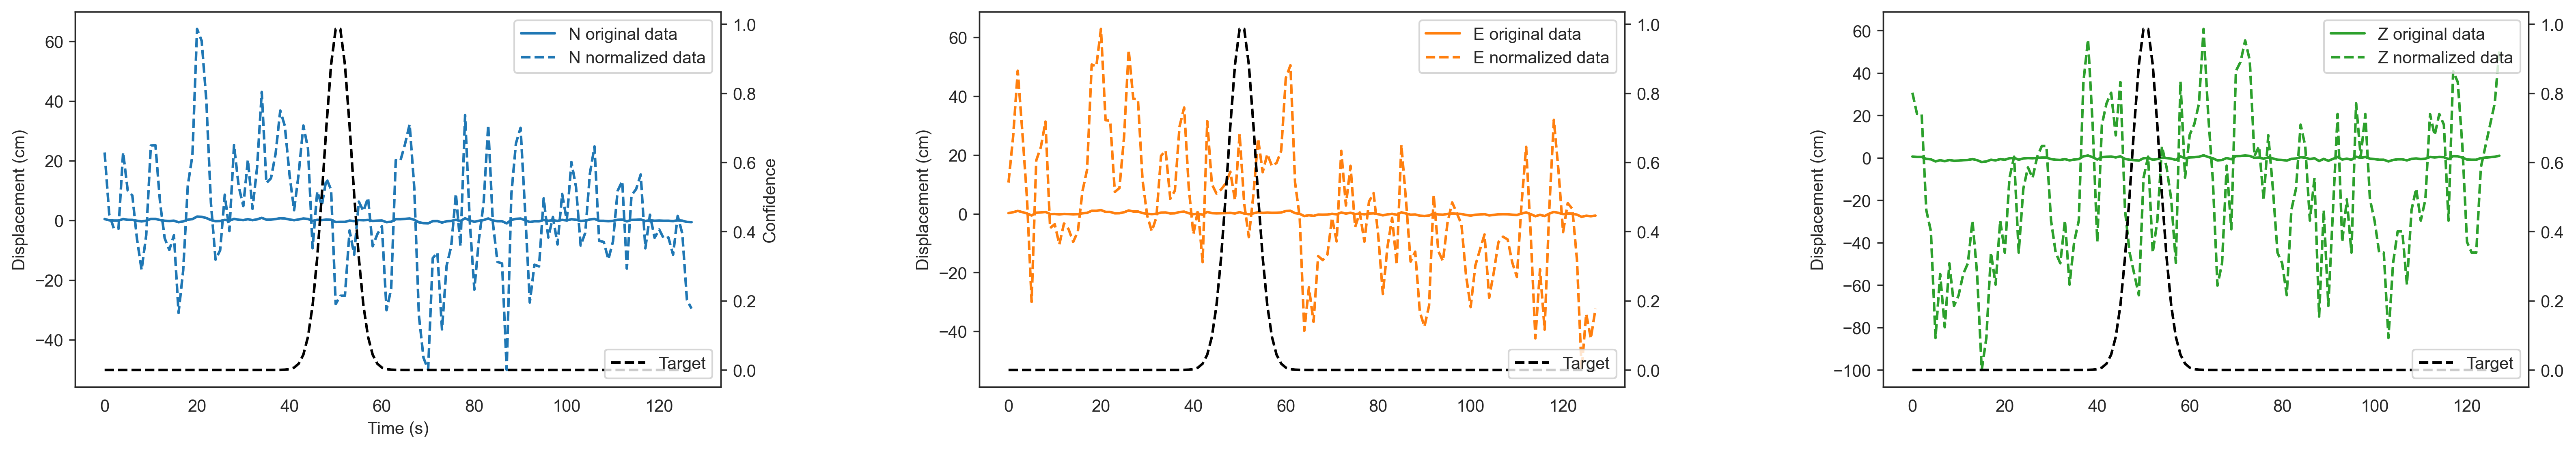

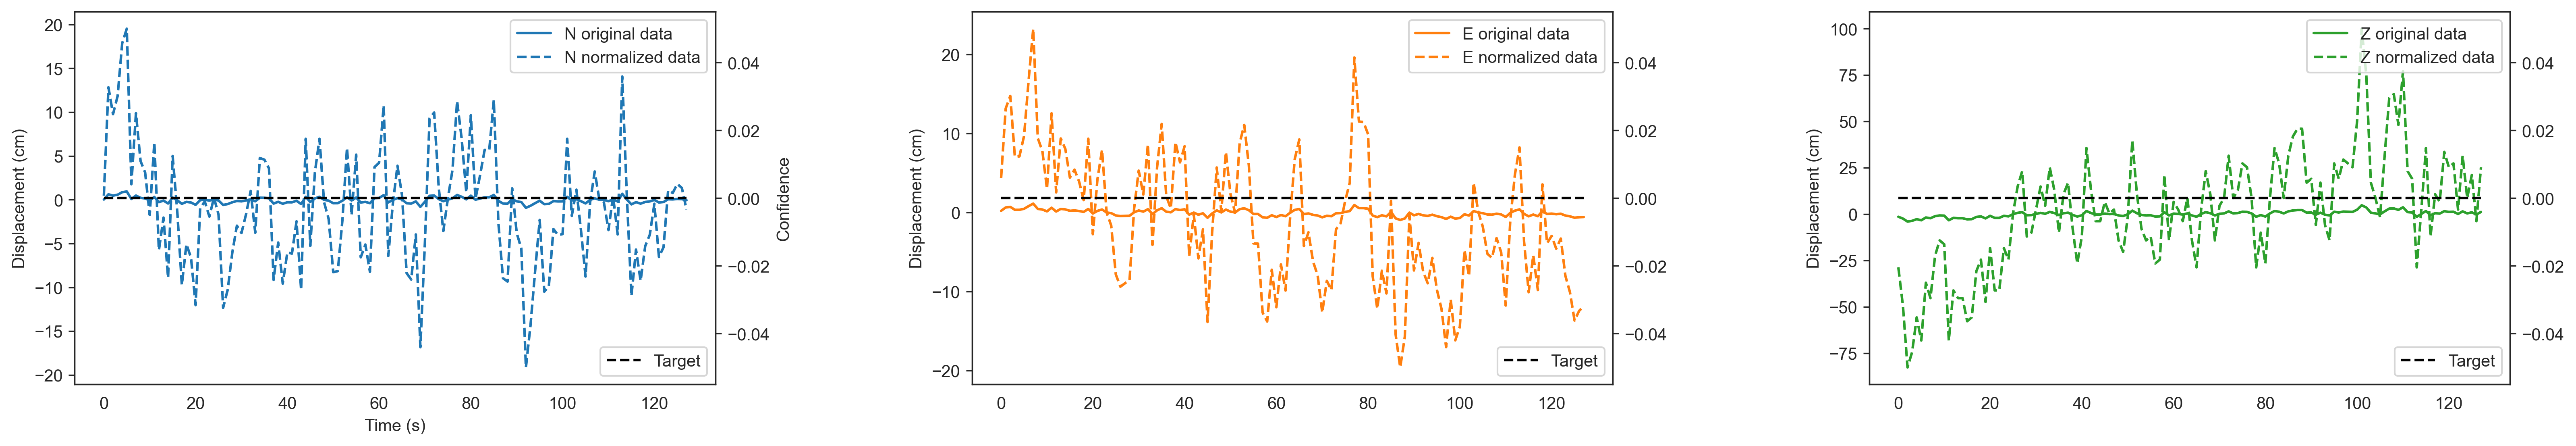

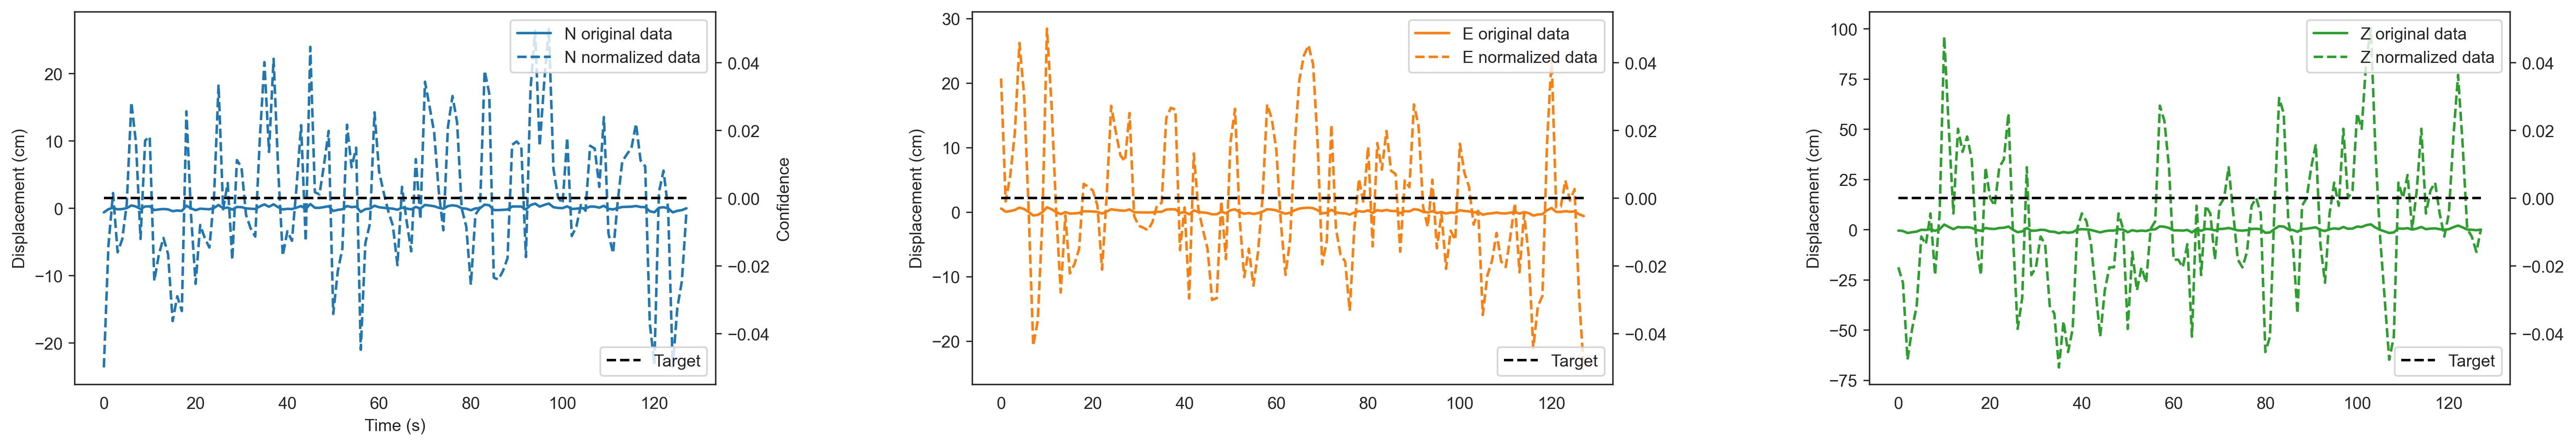

In [4]:
checkgen = X_gnss_unet_datagen_fn22.my_3comp_data_generator(32, fq_data, noise_data, fq_metadata, nan_array, train_fqinds, train_noiseinds, sr, std, valid = True) # Valid = True to get original data back
checkgen_orig_data, checkgen_norm_data, checkgen_target, checkgen_metadata = next(checkgen) 

print('Data generator check original data shape: ' + str(checkgen_orig_data.shape))
print('Data generator check normalized data shape: ' + str(checkgen_norm_data.shape))
print('Data generator check target shape: ' + str(checkgen_target.shape))
print('Data generator check metadata shape: ' + str(checkgen_metadata.shape))

# Shapes:
    # data: (batch_size, 128, 3) # N, E, Z
    # target: (batch_size, 128)
    # metadata: (batch_size, 3) Rupt name, station name, magnitude

# Plot generator results

nexamples = 10 # Number of examples to look at 
  
for ind in range(nexamples): 
    
#     print('Magnitude: ' + str(metadata[ind,2]))

    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (26,4), dpi = 300) # shoter for AGU talk
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(checkgen_orig_data.shape[1])
    
    ax1 = plt.subplot(131)
    ax1.plot(t, checkgen_orig_data[ind,:,0]*100, label = 'N original data', color = 'C0')
    ax1.plot(t, checkgen_norm_data[ind,:,0]*100, label = 'N normalized data', color = 'C0', linestyle = '--')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.set_ylabel('Confidence')
    ax2.legend(loc = 'lower right')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, checkgen_orig_data[ind,:,1]*100, label = 'E original data', color = 'C1')
    ax3.plot(t, checkgen_norm_data[ind,:,1]*100, label = 'E normalized data', color = 'C1', linestyle = '--')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.legend(loc = 'lower right')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, checkgen_orig_data[ind,:,2]*100, label = 'Z original data', color = 'C2')
    ax5.plot(t, checkgen_norm_data[ind,:,2]*100, label = 'Z normalized data', color = 'C2', linestyle = '--')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.legend(loc = 'lower right')
    
    plt.show()
#     plt.savefig(base_figure_save_dir + '3_ex' + str(ind) + '_plot_generator_pass.png', format = 'PNG')
#     plt.close()


## Model Construction

In [5]:
if drop: # Use a model with a dropout layer
    model = X_gnss_unet_datagen_fn22.make_large_unet_drop(fac, sr, ncomps = 3)
    print('Using model with dropout')
else:
    model = X_gnss_unet_datagen_fn22.make_large_unet(fac, sr, ncomps = 3)  
    print('Using large model')
    

2024-10-02 14:28:32.171454: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-02 14:28:32.171543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-10-02 14:28:32.171600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-10-02 14:28:32.171655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-10-02 14:28:32.171709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 16)      1024        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 64, 16)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64, 32)       7712        ['max_pooling1d[0][0]']          
                                                                                              

/home/sdybing/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Load an old trained model?

In [6]:
if load:
    loaddate = '2024-10-01' # Format: YYYY-MM-DD
    model_load_file = project_save_dir + 'models/traindate_' + str(loaddate) + '/bestmodel_traindate_' + str(loaddate) + '.h5'
    data_save_dir = models_path + 'traindate_' + str(loaddate) + '/data/' # Where to save the outputted testing data and predictions
    figure_save_dir = models_path + 'traindate_' + str(loaddate) + '/figures/'
    print('Loading training results from ' + model_load_file)
    
    model.load_weights(model_load_file)

Loading training results from /home/sdybing/gnss-picker/cnn_models_outputs/newfault_fq_train/models/traindate_2024-10-01/bestmodel_traindate_2024-10-01.h5


## Test the Model with Remaining FakeQuakes Data

### See how testing works with a smaller dataset (faster)?

In [7]:
if small_test:
    test_fqinds = test_fqinds[:100]
    test_noiseinds = test_noiseinds[:100]
    

### Test the model

In [8]:
fqtestdate = date.today()
num_fqtest = len(test_fqinds) # Number of samples to test with
# print(num_fqtest)

fqtestmodel = X_gnss_unet_datagen_fn22.my_3comp_data_generator(num_fqtest, fq_data, noise_data, fq_metadata, nan_array, test_fqinds, test_noiseinds, sr, std, valid = True)
fqtest_orig_data, fqtest_norm_data, fqtest_target, fqtest_metadata = next(fqtestmodel)
print('Predicting...')
fqtest_predictions = model.predict(fqtest_norm_data)

print('FQ test original data shape: ' + str(fqtest_orig_data.shape))
print('FQ test normalized data shape: ' + str(fqtest_norm_data.shape))
print('FQ test metadata shape: ' + str(fqtest_metadata.shape))
print('FQ test target shape: ' + str(fqtest_target.shape))
print('FQ test predictions shape: ' + str(fqtest_predictions.shape))


Predicting...
FQ test original data shape: (91740, 128, 3)
FQ test normalized data shape: (91740, 128, 3)
FQ test metadata shape: (91740, 3)
FQ test target shape: (91740, 128)
FQ test predictions shape: (91740, 128)


### Save the FQ testing data, targets, metadata, and predictions as .npys

In [9]:
np.save(data_save_dir + str(fqtestdate) + '_fqtest_orig_data.npy', fqtest_orig_data)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_norm_data.npy', fqtest_norm_data)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_metadata.npy', fqtest_metadata)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_target.npy', fqtest_target)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_predictions.npy', fqtest_predictions)


### Check PGD distribution of FQ testing data

In [12]:
fqtest_pgd = np.zeros(fqtest_orig_data.shape[0])
for idx in range(fqtest_orig_data.shape[0]):
    fqtest_pgd[idx] = np.max(np.sqrt((fqtest_orig_data[idx,:,0])**2 + (fqtest_orig_data[idx,:,1])**2 + (fqtest_orig_data[idx,:,2])**2))

plt.figure(figsize = (8,5), dpi = 300)
plt.hist(np.log10(fqtest_pgd), bins = 30, alpha = 0.5, edgecolor = 'black')
# plt.ylim(0,4000)

# plt.show()
plt.savefig(figure_save_dir + '5a_fqtestdata_pgd_distrib.png', format = 'PNG')
plt.close()

### Plot checks of FQ testing data and predictions

In [13]:
nexamples = 5 # Number of examples to look at 
  
for ind in range(nexamples): 
    
    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 300)
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(fqtest_orig_data.shape[1])
    # print(t)
    
    ax1 = plt.subplot(131)
    ax1.plot(t, fqtest_norm_data[ind,:,0], label = 'N test data', color = 'C0')
    ax1.set_ylabel('Displacement (m)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(-0.05,1.05)
    ax2.legend(loc = 'upper left')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, fqtest_norm_data[ind,:,1], label = 'E test data', color = 'C1')
    ax3.set_ylabel('Displacement (m)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax4.set_ylim(-0.05,1.05)
    ax4.legend(loc = 'upper left')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, fqtest_norm_data[ind,:,2], label = 'Z test data', color = 'C2')
    ax5.set_ylabel('Displacement (m)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax6.set_ylim(-0.05,1.05)
    ax6.legend(loc = 'upper left')
    
#     plt.show()
    plt.savefig(figure_save_dir + '6_fqtestdata_ex' + str(ind) + '_plot_test_predictions.png', format = 'PNG')
    plt.close()


## Test the Model with Real Data

### Run Real Data through Data Generator and Testing

In [14]:
realtestdate = date.today()

if small_test:
    realtest_data = real_data[:100]
    realtest_metadata = real_metadata[:100]
    num_realtest = len(realtest_data)
    realtestmodel = X_gnss_unet_datagen_fn22.real_data_generator(batch_size = num_realtest, data = realtest_data, meta_data = realtest_metadata, sr = 1, std = 3, nlen = 128)
    realtest_orig_data, realtest_norm_data, realtest_target = next(realtestmodel)
    
else:
    num_realtest = len(real_data) # Number of samples to test with
    realtestmodel = X_gnss_unet_datagen_fn22.real_data_generator(batch_size = num_realtest, data = real_data, meta_data = real_metadata, sr = 1, std = 3, nlen = 128)
    realtest_orig_data, realtest_norm_data, realtest_target = next(realtestmodel)
    realtest_metadata = real_metadata

print('Predicting...')
realtest_predictions = model.predict(realtest_norm_data)

print('Real test original data shape: ' + str(realtest_orig_data.shape))
print('Real test normalize data shape: ' + str(realtest_norm_data.shape))
print('Real test metadata shape: ' + str(realtest_metadata.shape))
print('Real test target shape: ' + str(realtest_target.shape))
print('Real test predictions shape: ' + str(realtest_predictions.shape))


Predicting...
Real test original data shape: (994155, 128, 3)
Real test normalize data shape: (994155, 128, 3)
Real test metadata shape: (994155, 7)
Real test target shape: (994155, 128)
Real test predictions shape: (994155, 128)


### Save the real testing data, targets, metadata, and predictions as .npys

In [15]:
np.save(data_save_dir + str(realtestdate) + '_realtest_orig_data.npy', realtest_orig_data)
np.save(data_save_dir + str(realtestdate) + '_realtest_norm_data.npy', realtest_norm_data)
np.save(data_save_dir + str(realtestdate) + '_realtest_metadata.npy', realtest_metadata)
np.save(data_save_dir + str(realtestdate) + '_realtest_target.npy', realtest_target)
np.save(data_save_dir + str(realtestdate) + '_realtest_predictions.npy', realtest_predictions)


### Check PGD distribution of real testing data

In [16]:
realtest_pgd = np.zeros(realtest_orig_data.shape[0])
for idx in range(realtest_orig_data.shape[0]):
    realtest_pgd[idx] = np.max(np.sqrt((realtest_orig_data[idx,:,0])**2 + (realtest_orig_data[idx,:,1])**2 + (realtest_orig_data[idx,:,2])**2))

max(realtest_pgd)

3.245717481790863

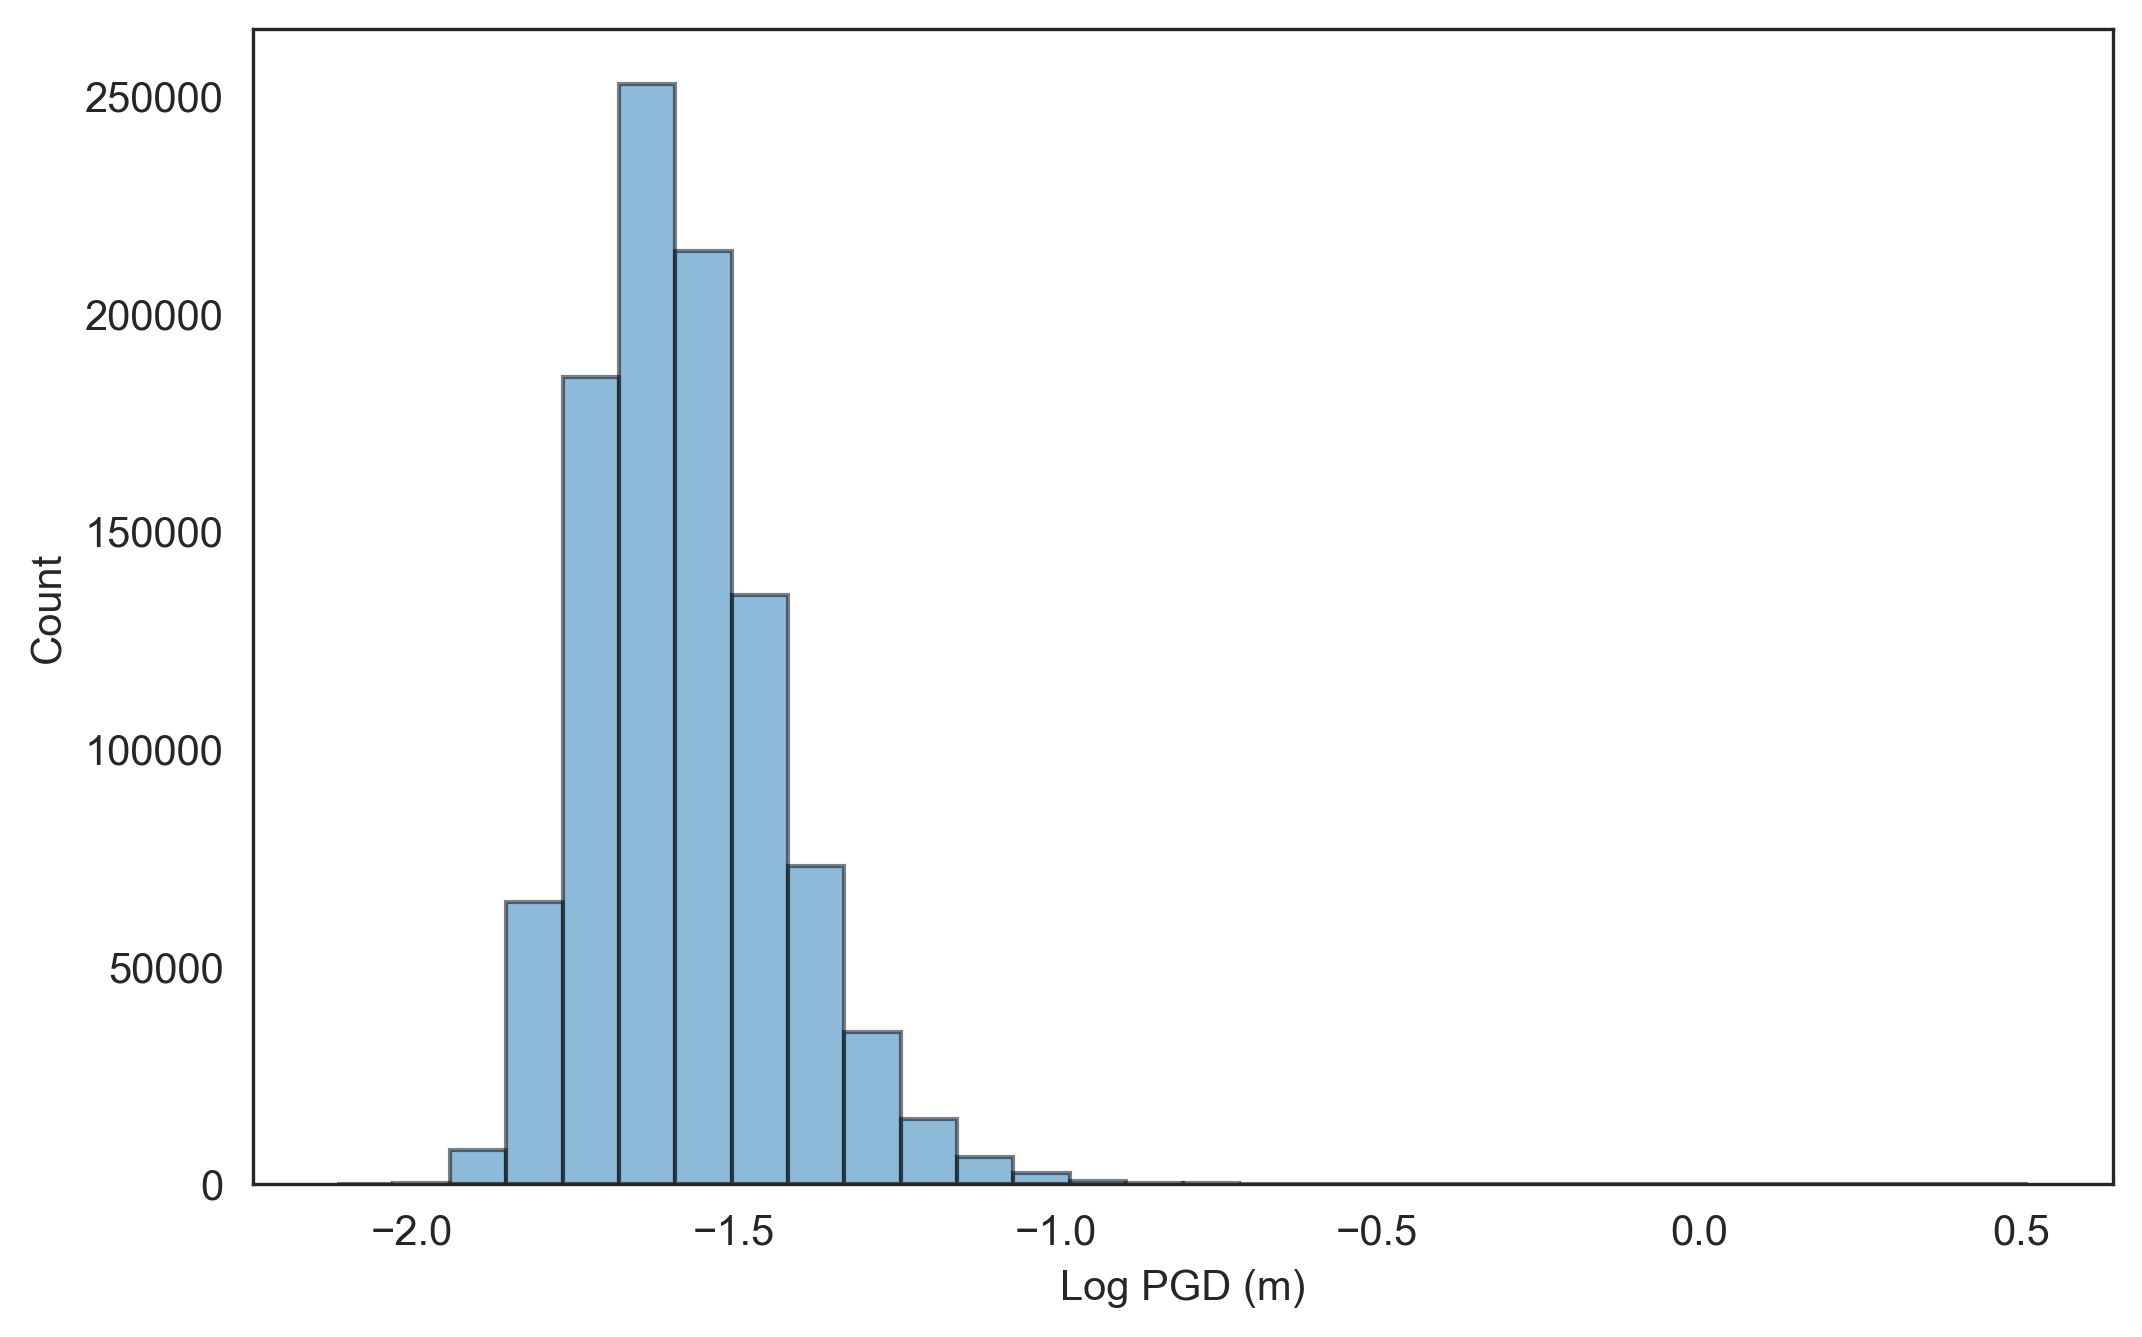

In [17]:
plt.figure(figsize = (8,5), dpi = 300)
plt.hist(np.log10(realtest_pgd), bins = 30, alpha = 0.5, edgecolor = 'black')
plt.xlabel('Log PGD (m)')
plt.ylabel('Count')
# plt.ylim(0,1000)

plt.show();
# plt.savefig(figure_save_dir + '15_realtestdata_pgd_distrib.png', format = 'PNG')
# plt.close();


In [18]:
rows_w_eqs = np.load(realdata_dir + 'real_metadata_rembad_rows_w_eqs.npy')
print(rows_w_eqs)

print(realtest_metadata[rows_w_eqs][:,6])


[  1473   4079  15197 ... 992695 992821 993524]
['4.85' '4.74' '6.40' ... '4.47' '4.74' '5.51']


### Plot checks of real testing data and predictions

In [ ]:
nexamples = 5 # Number of examples to look at 
  
# for ind in range(nexamples):
# for ind in rows_w_eqs[:5]:
counter = 0
for ind in rows_w_eqs: # To save all earthquake examples
#     print(ind)
    counter += 1
    print('Real earthquake ' + str(counter) + '/' + str(len(rows_w_eqs)))
    
    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 100)
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(realtest_orig_data.shape[1])
    # print(t)
    
    ax1 = plt.subplot(131)
    ax1.plot(t, realtest_norm_data[ind,:,0]*100, label = 'N test data', color = 'C0')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(-0.05,1.05)
    ax2.legend(loc = 'upper left')
    
    ax3 = plt.subplot(132)
    ax3.set_title('Row with earthquake ' + str(ind), fontsize = 16)
    ax3.plot(t, realtest_norm_data[ind,:,1]*100, label = 'E test data', color = 'C1')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax4.set_ylim(-0.05,1.05)
    ax4.legend(loc = 'upper left')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, realtest_norm_data[ind,:,2]*100, label = 'Z test data', color = 'C2')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax6.set_ylim(-0.05,1.05)
    ax6.legend(loc = 'upper left')
    
#     plt.show()
#     plt.savefig(figure_save_dir + '16_realtestdata_ex' + str(ind) + '_plot_predictions.png', format = 'PNG')

    plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')
    plt.close()
    

Real earthquake 1/2123
Real earthquake 2/2123
Real earthquake 3/2123
Real earthquake 4/2123
Real earthquake 5/2123
Real earthquake 6/2123
Real earthquake 7/2123
Real earthquake 8/2123
Real earthquake 9/2123
Real earthquake 10/2123
Real earthquake 11/2123
Real earthquake 12/2123
Real earthquake 13/2123
Real earthquake 14/2123
Real earthquake 15/2123
Real earthquake 16/2123
Real earthquake 17/2123
Real earthquake 18/2123
Real earthquake 19/2123
Real earthquake 20/2123
Real earthquake 21/2123
Real earthquake 22/2123
Real earthquake 23/2123
Real earthquake 24/2123
Real earthquake 25/2123
Real earthquake 26/2123
Real earthquake 27/2123
Real earthquake 28/2123
Real earthquake 29/2123
Real earthquake 30/2123
Real earthquake 31/2123
Real earthquake 32/2123
Real earthquake 33/2123
Real earthquake 34/2123
Real earthquake 35/2123
Real earthquake 36/2123
Real earthquake 37/2123
Real earthquake 38/2123
Real earthquake 39/2123
Real earthquake 40/2123
Real earthquake 41/2123
Real earthquake 42/2123
R

In [25]:
nexamples = 5 # Number of examples to look at 
  
# for ind in range(nexamples):
# for ind in rows_w_eqs[:5]:

for ind in rows_w_eqs: # To save all earthquake examples
#     print(ind)
    
#     if max(realtest_predictions[ind,:]) > 0.7:
    if max(realtest_predictions[ind,:]) > 0.1:
        
        print(ind)
        n_data = realtest_orig_data[ind,:,0]
        e_data = realtest_orig_data[ind,:,1]
        z_data = realtest_orig_data[ind,:,2]
        pgd = np.max(np.sqrt((n_data)**2+(e_data)**2+(z_data)**2))
    
        fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 100)
        plt.subplots_adjust(wspace = 0.4)
        t = 1/sr * np.arange(realtest_orig_data.shape[1])
        # print(t)

        ax1 = plt.subplot(131)
        ax1.plot(t, realtest_orig_data[ind,:,0], label = 'N test data', color = 'C0')
        ax1.set_ylabel('Displacement (m)')
        ax1.set_xlabel('Time (s)')
        ax1.legend(loc = 'upper right')
        ax2 = ax1.twinx()
        ax2.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax2.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax2.set_ylabel('Confidence')
        ax2.set_ylim(-0.05,1.05)
        ax2.legend(loc = 'upper left')

        ax3 = plt.subplot(132)
        ax3.set_title('Row with earthquake ' + str(ind) + ': station ' + str(realtest_metadata[ind,0]) + ', magnitude ' + str(realtest_metadata[ind,6]) + ', PGD ' + str(np.round(pgd,3)) + ' m', fontsize = 16)
        ax3.plot(t, realtest_orig_data[ind,:,1], label = 'E test data', color = 'C1')
        ax3.set_ylabel('Displacement (m)')
        ax3.legend(loc = 'upper right')
        ax4 = ax3.twinx()
        ax4.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax4.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax4.set_ylim(-0.05,1.05)
        ax4.legend(loc = 'upper left')

        ax5 = plt.subplot(133)
        ax5.plot(t, realtest_orig_data[ind,:,2], label = 'Z test data', color = 'C2')
        ax5.set_ylabel('Displacement (m)')
        ax5.legend(loc = 'upper right')
        ax6 = ax5.twinx()
        ax6.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax6.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax6.set_ylim(-0.05,1.05)
        ax6.legend(loc = 'upper left')

#         plt.show()
    #     plt.savefig(figure_save_dir + '16_realtestdata_ex' + str(ind) + '_plot_predictions.png', format = 'PNG')
#         plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/conf_over_70/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')

        plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/conf_over_10/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')
        plt.close()


25610
25758
33602
81069
81120
82015
82030
82285
86484
90083
94537
95601
100785
133653
153127
159433
196009
196813
196825
196828
196832
200591
210347
221038
229639
233925
234760
239937
250560
260214
260252
275442
296806
301182
310589
312228
316072
316894
316900
316914
317067
321618
397905
402342
402346
402615
406381
406415
411749
411759
416210
421620
422576
438987
465317
538654
558835
558993
563447
563994
579515
579635
580454
594992
598949
599080
599222
599244
604520
604796
608048
608992
613950
627139
630389
635107
635119
635378
639421
642630
642827
642849
646752
647106
647203
651763
652036
656197
656486
659041
660871
660884
666217
670943
676348
681732
686850
696500
701472
708342
709342
729147
729424
732243
732375
733194
733471
845729
850469
856654
861360
866691
892726
904922
922466
922732
926253
941730
948698
948974
964205


2123
121


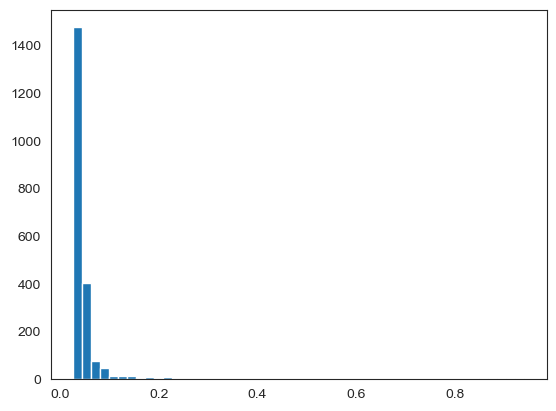

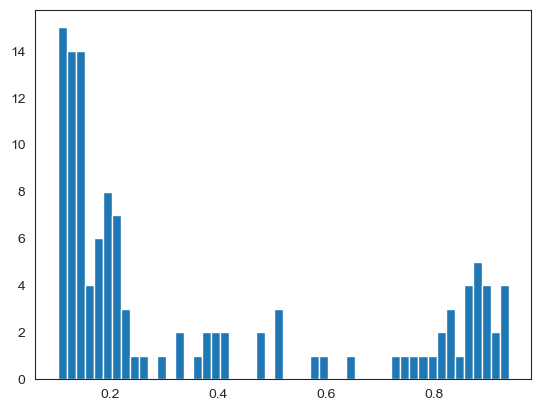

In [26]:
# Checking confidence distribution of predictions on the earthquake samples

peaks = []
peaks_above_01 = []

for ind in rows_w_eqs:
    peak = max(realtest_predictions[ind,:])
    peaks.append(peak)
    if peak >= 0.1:
        peaks_above_01.append(peak)
    
print(len(peaks))
print(len(peaks_above_01))

plt.hist(peaks, bins = 50)
plt.show()

plt.hist(peaks_above_01, bins = 50)
plt.show();